# CORD-19-analyse-fetched-coredata

In general, this jupyter notebook is designated to analyse fetched coredata. Thusly, an API-call is described: 
https://api.elsevier.com/content/search/scopus?query=DOI(10.1109/MCOM.2016.7509373)&apiKey=6d485ef1fe1408712f37e8a783a285a4

First, relevant packages must be imported to the Notebook.

In [1]:
import numpy as np
import pandas as pd
import csv
import ast
import collections
import matplotlib.pyplot as plt
import Levenshtein as lev
from fuzzywuzzy import fuzz 
import datetime
import matplotlib.pyplot as plt
import re
from urllib.parse import urlparse
from collections import Counter

from elsapy.elsclient import ElsClient
from elsapy.elsdoc import FullDoc, AbsDoc
from elsapy.elssearch import ElsSearch

import time # for sleep
from pybtex.database import parse_file, BibliographyData, Entry
import json
from elsapy.elsclient import ElsClient
from elsapy.elsdoc import AbsDoc
from elsapy.elssearch import ElsSearch

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

import folium
import pycountry

Thusly, the fetched coredata and affiliation are read from the pkl-files and combined to a DataFrame for further processing. 

In [2]:
read_coredata = pd.read_pickle('extra_info_coredata_CS5099.pkl')
df_current_extra_info = pd.DataFrame()
df_current_extra_info['coredata'] = read_coredata
df_current_extra_info

,coredata
0,"{'srctype': 'j', 'prism:issueIdentifier': '230..."
1,"{'srctype': 'j', 'eid': '2-s2.0-85083171050', ..."
2,None
3,"{'srctype': 'j', 'eid': '2-s2.0-79953057246', ..."
4,"{'srctype': 'j', 'prism:issueIdentifier': '7',..."
...,...
74297,"{'srctype': 'j', 'prism:issueIdentifier': '4',..."
74298,"{'srctype': 'j', 'prism:issueIdentifier': '12 ..."
74299,"{'srctype': 'j', 'eid': '2-s2.0-85091772561', ..."
74300,"{'srctype': 'j', 'prism:issueIdentifier': '6',..."


In [3]:
df_current_extra_info.isnull().sum()

coredata    13897
dtype: int64

In [4]:
df_current_extra_info.isnull().sum() / len(df_current_extra_info)

coredata    0.187034
dtype: float64

Compared to the length of the dataset, a fifth of fetched scopus data has no return value.

Thusly, all rows which contain "None" values are dropped and the DataFrame is reindexed. 

In [4]:
df_combined = df_current_extra_info.dropna()
df_combined = df_combined.reset_index(drop=True)
df_combined

,coredata
0,"{'srctype': 'j', 'prism:issueIdentifier': '230..."
1,"{'srctype': 'j', 'eid': '2-s2.0-85083171050', ..."
2,"{'srctype': 'j', 'eid': '2-s2.0-79953057246', ..."
3,"{'srctype': 'j', 'prism:issueIdentifier': '7',..."
4,"{'srctype': 'j', 'eid': '2-s2.0-85091848821', ..."
...,...
60400,"{'srctype': 'j', 'prism:issueIdentifier': '4',..."
60401,"{'srctype': 'j', 'prism:issueIdentifier': '12 ..."
60402,"{'srctype': 'j', 'eid': '2-s2.0-85091772561', ..."
60403,"{'srctype': 'j', 'prism:issueIdentifier': '6',..."


The following functions support the creation of DataFrames based on the columns affiliation and coredata. 

In [5]:
def get_one_entry(dic):
    df_affiliation_holder = pd.DataFrame(dic.items()).T
    df_affiliation_holder.columns = df_affiliation_holder.iloc[0]
    df_affiliation_holder = df_affiliation_holder.drop(df_affiliation_holder.index[0])
    return df_affiliation_holder

In [6]:
def get_various_entries(dic):
    df_affiliation_holder = pd.DataFrame.from_dict(dic, orient='columns')
    return df_affiliation_holder

The next cell creates the DataFrame which focus on coredata. 

In [7]:
%%time
df_coredata = pd.DataFrame()
df_coredata_holder = pd.DataFrame()

for i in df_combined['coredata']:
    string_holder = str(i)
    if string_holder[0] == "[":
        df_coredata_holder = get_various_entries(i)
    else: 
        df_coredata_holder = get_one_entry(i)
    df_coredata = pd.concat([df_coredata_holder, df_coredata],ignore_index=True)
df_coredata

Wall time: 4h 30min 56s


,srctype,prism:issueIdentifier,eid,prism:coverDate,prism:aggregationType,prism:url,subtypeDescription,dc:creator,link,prism:publicationName,...,prism:issn,article-number,dc:identifier,dc:publisher,pubmed-id,prism:pageRange,prism:endingPage,prism:startingPage,pii,prism:isbn
0,j,5,2-s2.0-85057840602,2018-04-26,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"{'author': [{'ce:given-name': 'Chien-Chih', 'p...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Entropy,...,10994300,320,SCOPUS_ID:85057840602,MDPI AGPostfachBaselCH-4005indexing@mdpi.com,NaN,NaN,NaN,NaN,NaN,NaN
1,j,6,2-s2.0-85097986550,2020-12-01,Journal,https://api.elsevier.com/content/abstract/scop...,Review,"{'author': [{'ce:given-name': 'Zaid', 'preferr...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",mSystems,...,23795077,00999,SCOPUS_ID:85097986550,American Society for Microbiology,NaN,NaN,NaN,NaN,NaN,NaN
2,j,6,2-s2.0-85091772561,2021-06-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"{'author': [{'ce:given-name': 'Richard', 'pref...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Addiction,...,13600443 09652140,NaN,SCOPUS_ID:85091772561,Blackwell Publishing Ltd,32945597,1600-1605,1605,1600,NaN,NaN
3,j,12 December,2-s2.0-85097843658,2020-12-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"{'author': [{'ce:given-name': 'Martina', 'pref...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",PLoS ONE,...,19326203,e0242914,SCOPUS_ID:85097843658,Public Library of Science,33296395,NaN,NaN,NaN,NaN,NaN
4,j,4,2-s2.0-85091314414,2020-12-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"{'author': [{'ce:given-name': 'Linda JL', 'pre...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Outlook on Agriculture,...,00307270,NaN,SCOPUS_ID:85091314414,SAGE Publications Inc. claims@sagepub.com,NaN,321-329,329,321,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60400,j,1,2-s2.0-85091848821,2021-02-01,Journal,https://api.elsevier.com/content/abstract/scop...,Note,"{'author': [{'ce:given-name': 'Manahal', 'pref...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Clinical Teacher,...,1743498X 17434971,NaN,SCOPUS_ID:85091848821,Blackwell Publishing Ltd,33006439,90-91,91,90,NaN,NaN
60401,j,7,2-s2.0-85049437388,2018-01-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"{'author': [{'ce:given-name': 'Fei', 'preferre...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Molecules,...,14203049,1599,SCOPUS_ID:85049437388,MDPI AGPostfachBaselCH-4005,30004408,NaN,NaN,NaN,NaN,NaN
60402,j,4,2-s2.0-79953057246,2011-04-01,Journal,https://api.elsevier.com/content/abstract/scop...,Review,"{'author': [{'ce:given-name': 'Val', 'preferre...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",The Lancet Infectious Diseases,...,14733099,NaN,SCOPUS_ID:79953057246,NaN,21453872,312-321,321,312,S1473309910702243,NaN
60403,j,4,2-s2.0-85083171050,2020-07-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"{'author': [{'ce:given-name': 'Raju', 'preferr...","[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Diabetes and Metabolic Syndrome: Clinical Rese...,...,18780334 18714021,NaN,SCOPUS_ID:85083171050,Elsevier Ltd,32305024,337-339,339,337,S1871402120300771,NaN


In [8]:
# Due to ethical constraints the information linke to the creator (author) of the paper are removed before saving to the storage
del df_coredata['dc:creator']

In [9]:
df_coredata

,srctype,prism:issueIdentifier,eid,prism:coverDate,prism:aggregationType,prism:url,subtypeDescription,link,prism:publicationName,source-id,...,prism:issn,article-number,dc:identifier,dc:publisher,pubmed-id,prism:pageRange,prism:endingPage,prism:startingPage,pii,prism:isbn
0,j,5,2-s2.0-85057840602,2018-04-26,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Entropy,13715,...,10994300,320,SCOPUS_ID:85057840602,MDPI AGPostfachBaselCH-4005indexing@mdpi.com,NaN,NaN,NaN,NaN,NaN,NaN
1,j,6,2-s2.0-85097986550,2020-12-01,Journal,https://api.elsevier.com/content/abstract/scop...,Review,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",mSystems,21100850723,...,23795077,00999,SCOPUS_ID:85097986550,American Society for Microbiology,NaN,NaN,NaN,NaN,NaN,NaN
2,j,6,2-s2.0-85091772561,2021-06-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Addiction,24745,...,13600443 09652140,NaN,SCOPUS_ID:85091772561,Blackwell Publishing Ltd,32945597,1600-1605,1605,1600,NaN,NaN
3,j,12 December,2-s2.0-85097843658,2020-12-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",PLoS ONE,10600153309,...,19326203,e0242914,SCOPUS_ID:85097843658,Public Library of Science,33296395,NaN,NaN,NaN,NaN,NaN
4,j,4,2-s2.0-85091314414,2020-12-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Outlook on Agriculture,33310,...,00307270,NaN,SCOPUS_ID:85091314414,SAGE Publications Inc. claims@sagepub.com,NaN,321-329,329,321,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60400,j,1,2-s2.0-85091848821,2021-02-01,Journal,https://api.elsevier.com/content/abstract/scop...,Note,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Clinical Teacher,4500151406,...,1743498X 17434971,NaN,SCOPUS_ID:85091848821,Blackwell Publishing Ltd,33006439,90-91,91,90,NaN,NaN
60401,j,7,2-s2.0-85049437388,2018-01-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Molecules,26370,...,14203049,1599,SCOPUS_ID:85049437388,MDPI AGPostfachBaselCH-4005,30004408,NaN,NaN,NaN,NaN,NaN
60402,j,4,2-s2.0-79953057246,2011-04-01,Journal,https://api.elsevier.com/content/abstract/scop...,Review,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",The Lancet Infectious Diseases,22471,...,14733099,NaN,SCOPUS_ID:79953057246,NaN,21453872,312-321,321,312,S1473309910702243,NaN
60403,j,4,2-s2.0-85083171050,2020-07-01,Journal,https://api.elsevier.com/content/abstract/scop...,Article,"[{'@_fa': 'true', '@rel': 'self', '@href': 'ht...",Diabetes and Metabolic Syndrome: Clinical Rese...,5700165201,...,18780334 18714021,NaN,SCOPUS_ID:85083171050,Elsevier Ltd,32305024,337-339,339,337,S1871402120300771,NaN


In [58]:
ser_type = df_coredata['prism:aggregationType']
ser_type_counted = ser_type.value_counts()
ser_type_counted

Journal                  57194
Book Series               2424
Book                       557
Conference Proceeding      215
Trade Journal               12
Name: prism:aggregationType, dtype: int64

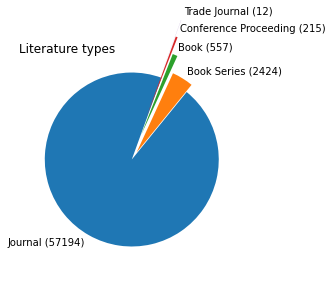

In [142]:
ser_type_dict = {}
len_ser_type_counted  = len(ser_type_counted)
i = 0
while i < len_ser_type_counted:
    ser_type_dict[i] = ser_type_counted.index[i] + " (" + str(ser_type_counted.values[i]) + ")"
    i = i + 1 

y = ser_type_counted.values
labelling = ser_type_dict.values()
shift = [-0.1, 0.2, 0.4, 0.6, 0.8]

plt.pie(y, labels = labelling, startangle = 70, explode = shift)
plt.title("Literature types", loc="left")
plt.show() 

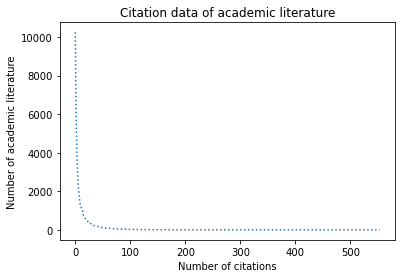

In [135]:
ser_citedcount = df_coredata['citedby-count']
ser_citedcount_counted = ser_citedcount.value_counts()
ypoints = ser_citedcount_counted.values

plt.plot(ypoints, linestyle = 'dotted')
plt.xlabel("Number of citations")
plt.ylabel("Number of publications")
plt.title("Citation data of academic literature")
plt.show()

In [134]:
ser_citedcount_counted 

0      10241
1       7308
2       5223
3       3758
4       3116
       ...  
442        1
941        1
924        1
865        1
288        1
Name: citedby-count, Length: 554, dtype: int64